# Building the [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762) "Vanilla" Transformer from scratch.

In [ ]:
import os
import sys
import math
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# Task 1: Transformers from Scratch
Here we will build the famous 2017 Transformer Encoder-Decoder from the Paper [Attention is All You Need](https://arxiv.org/abs/1706.03762).

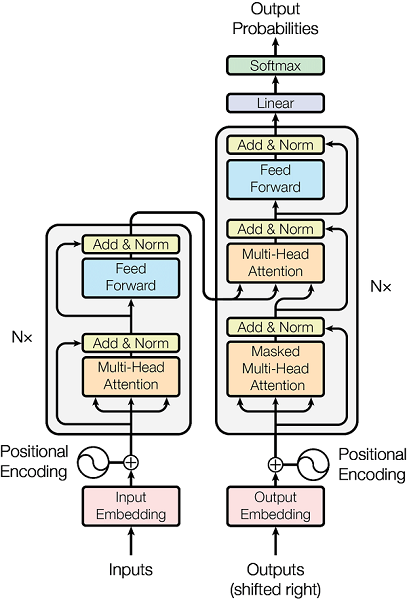![](img/transformer.png)

## Task 1.1: Scaled Dot-Product Attention and Multi-Head Attention
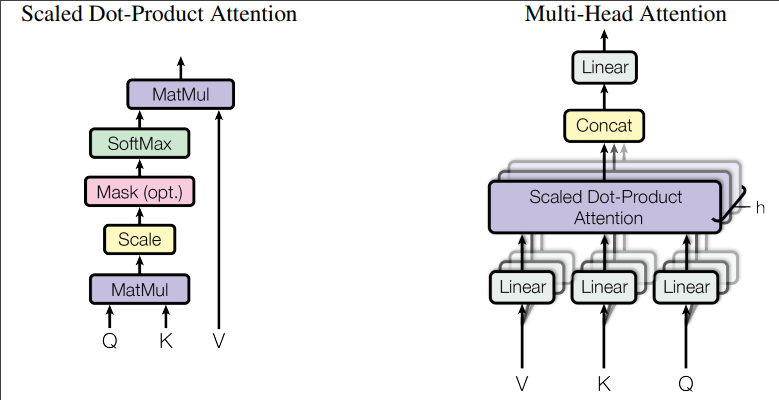![](img/mha.png)

We will start by implementing Multi-Head Attention, which concatenates multiple single scaled dot-product attention (SDPA) modules along the number of attention heads we desire. However, as concatenation implies sequential procedures, we will directly implement multi-head attention as a tensor operation on `nn.Linear()` layers by dividing them into `num_heads` subparts and calculating SDPA on each of them. By doing this, we entirely avoided sequential calculations.

In order to have trainable parameters, we can conveniently build all modules using torch's `nn.Module` functionality.

* Our module's `__init__()` method takes in the embedding dimension `emb_dim` of our transformer, as well as the number of heads `num_heads`.
    * It stores the `head_dim = emb_dim // num_heads`
* We create 4 linear layers
    * The linear layers for query, key, and value each have `(emb_dim, num_heads * head_dim)` size
    * The output linear layer needs to take the `num_heads * head_dim` as input size, and outputs the original model embedding dimension `emb_dim`
* The `forward()` method of this module takes in `query`, `key`, `value`, and an optional `mask`, and performs the calculations of the following formula:
    * 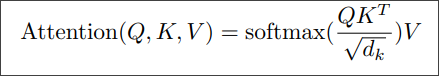![](img/attention.png)
    * Remember that our input at this stage has dimensions `(batch_size, seq_len, emb_dim)`   
    * We pass `query`, `key`, `value` through their respective linear layers
    * Then, we perform the multi-head splitting of the linearly projected outputs
        * each projection's hidden dimension has to be reshaped to fit the `num_heads` and `head_dim` structure (in that order)
        * Hint: Both `batch_size` and `seq_len` shouldn't be changed
    * Afterwards, we perform the matrix multiplication step of queries with their transposed keys, visualized by the $QK^T$ in the above formula
    * Hint: The output shape after this step should be `(batch_size, num_heads, num_query_seq, num_key_seq)`
    * Call this output `key_out`
    * After this step, add in the optional step to mask the `key_out` tensor. We provided this code snipped, just include it at this step in the forward pass
    * Following this, we perform the softmax step on the result of the division from `key_out` with the square root of our `head_dim`
        * Make sure to apply softmax to the correct dimension
    * Now we need just need to matrix multiply this result with the values (which were passed through their respective linear layer earlier)
    * The output shape of this operation is `(batch_size, seq_len, num_heads, head_dim)`
    * Reshape it to fit the input shape of our output linear layer
    * Pass it through the ouput linear layer

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()

        # TODO

    def forward(self, query, key, value, mask=None):
        # TODO

        if mask is not None:
            key_out = key_out.masked_fill(mask == 0, -1e20)

        return # TODO

## Task 1.2: Transformer Blocks
We will now create Transformer Blocks out of our `MultiHeadAttention` module, combined with Feedforward-Networks.

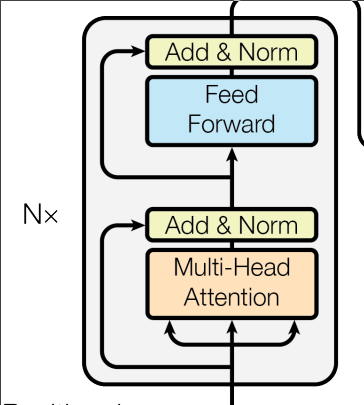![](img/transformer_block.png)

* To create the blocks, our module takes as input in it's `__init__` method:
    * the embedding dimension `emb_dim`, the number of heads `num_heads`, a dropout rate `dropout`, and the dimension of the hidden layer in the feedforward network, often called `forward_dim`
    * in the `__init__` method, we further need two `nn.Layernorm` objects with an epsilon parameter `eps=1e-6`
    * then, still in the `__init__` method, we set up the feedforward network
    * 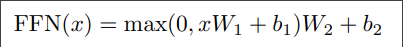![](img/ffn.png)
    * we build it by creating an `nn.Sequential` module and filling it with:
        * a linear layer projecting the input onto the `forward_dim`
        * running it through `nn.ReLU`
        * and projecting the `forward_dim` back to the embedding dimension with another linear layer
* the `forward()` method takes `query`, `key`, `value` and the `mask`
    * first, we run `query`, `key`, `value`, and the `mask` through multi-head attention
    * secondly, we build a skip-connection by adding the `query` back to the output of multi-head attention
        * dropout is applied to the sum, followed by our first layer norm
    * third, the output is put through our FFN
    * fourth, we build another skip-connection by adding the input of the FFN onto the output of the FFN
    * apply dropout to the result of the skip-connection, apply normalization on the dropped-out result, and return it

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, dropout, forward_dim):
        super().__init__()

        # TODO

    def forward(self, query, key, value, mask):
        # TODO

        return # TODO

This already convenes the encoder side of the transformer. We now just need to incorporate it into an appropriate format so that it can take input sequences, move them to the GPU, etc. To achieve this, we create another module called `Encoder`.

## Task 1.3 Encoder
* The `Encoder` takes as input in its `__init__` method:
    * the (source) vocabulary size `vocab_size`, embedding dimension `emb_dim`, number of layers `num_layers`, number of heads `num_heads`, feedforward-dimension `forward_dim`, the dropout rate `dropout`, and the maximum sequence length `max_len`
    * Note that the preprocessing, in this case the truncation of sequences to the maximum allowed length, is handled in the data loading process that we performed in the first exercise while loading the sequences. Here, we define the model architecture that (usually) dictates the necessary preprocessing steps.
    * We then define
        * the token level embeddings with dimensions `vocab_size x emb_dim`
        * positional encodings with the sinusoidal approach (function is given below)
            * You need to create an additional `nn.Embedding` layer and load in the sinusoid table with the `.from_pretrained` method
            * Freeze these embeddings
        * a dropout layer
        * and, lastly, instantiate `num_layers` many `TransformerBlock` modules inside an `nn.ModuleList`
* In the `forward()` method, we take in the batched sequence inputs, as well as a mask
    * Then, we create the input to the positional encodings by defining a matrix which represents the index of each token in the sequence
        * Move the positions to the device on which the batched sequences are located
        * Make sure to shift each index by `+1` (and the `max_len` in the creation of the sinusoidal table, too)
        * This is done because index `0` is usually reserved for special tokens like `[PAD]`, which don't need a positional encoding.
    * We then run our input through the embeddings, the above create positions are run through the positional encodings, and both results are summed up
    * Apply dropout to the summed up result
    * This will be our `query`, `key`, and `value` input that runs `num_layers` times through our encoder module list
    * Return the last output

In [ ]:
def get_sinusoid_table(max_len, emb_dim):
    def get_angle(pos, i, emb_dim):
        return pos / 10000 ** ((2 * (i // 2)) / emb_dim)

    sinusoid_table = torch.zeros(max_len, emb_dim)
    for pos in range(max_len):
        for i in range(emb_dim):
            if i % 2 == 0:
                sinusoid_table[pos, i] = math.sin(get_angle(pos, i, emb_dim))
            else:
                sinusoid_table[pos, i] = math.cos(get_angle(pos, i, emb_dim))
    return sinusoid_table

In [ ]:
class Encoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        num_layers,
        num_heads,
        forward_dim,
        dropout,
        max_len,
    ):
        super().__init__()

        # TODO

    def forward(self, x, mask):
        # TODO

        return # TODO

## Task 1.4: Decoder Blocks
Now to the decoder part!

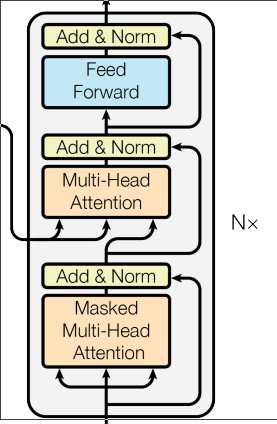![](img/decoder_block.png)

A `DecoderBlock` looks very similar to our previous `TransformerBlock`, but slightly extends the functionality because at its second stage, it receives inputs from both the encoder and its first stage (look closely at the input arrows in the picture!)

* To build one, the module's `__init__` method takes as input:
    * the embedding dimension `emb_dim`, number of heads `num_heads`, a feedforward dimension `forward_dim`, and a `dropout` rate
    * It then initializes:
        * an `nn.LayerNorm` with `eps=1e-6`, the `MultiHeadAttention` module, a `TransformerBlock`, and the dropout rate
* The decoder block's `forward()` method takes:
    * the batched sequence input, `value`, `key`, a source mask, and a target mask
    * First, we compute *self-attention* representations of the input (i.e., the input serves as `query`, `key`, and `value`), and takes the *target mask* for the mask parameter
        * This is the input that is symbolized by the arrow coming from the bottom of the image
    * Secondly, we use a skip-connection by summing up the above self-attention result with the original input (again, apply dropout here and normalize the result)
        * This output is our new `query`
    * We now run this above created `query` as the query-input through a `TransformerBlock`, where the `value` and `key` arguments for the `TransformerBlock` come from the `Encoder` output
        * This is called *cross-attention*
        * Include the source mask as the `mask` argument in the `TransformerBlock`
        * return the output of the `TransformerBlock`

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, forward_dim, dropout):
        super().__init__()

        # TODO

    def forward(self, x, value, key, src_mask, tgt_mask):
        # TODO

        return # TODO

As we could see from the large overview of the transformer architecture, this is already most of what is happening on the decoder side. Similar to our `Encoder`, we now must enable the `DecoderBlock` to take external input and embed its own sequences. We will do this in the `Decoder` module below.

## Task 1.5: Decoder
The `Decoder`'s `__init__` method
* takes as input:
    * the (target) vocabulary size `vocab_size`, embedding dimension `emb_dim`, number of layers `num_layers`, number of heads `num_heads`, the hidden dimensionality `forward_dim` of the feedforward module, as well as the maximum sequence length `max_len`

    * We then initialize:
        * token embeddings, a dropout layer, and `num_layers` many `DecoderBlocks` inside another `nn.ModuleList`
        * We also need positional encodings, but here we don't use sinusoidal embeddings, but instead something called *relative positional encodings*, which capture the relative position between the decoder input tokens and the output tokens at each decoding step
            * They are trainable, and are implemented by another `nn.Embedding` layer, but with dimensions `max_len x emb_dim`
        * lastly, we need a linear output layer which maps the embedding dimension back to the vocabulary size

* The modules `forward()` pass then takes as input the batched sequence input, the encoder output, and a source and target mask
    * The decoder then:
        * processes the sequences through our normal embeddings
        * creates inputs to the relative positional encodings by again creating a matrix of position indices from each token in the sequence (no `+1` shifting this time because we train each position relative to the current encoded sequence position output)
        * The inputs again need to be moved to the batched sequence input's device
        * runs these positions through the relative positional encodings, and sums them up with the token embeddings
            * apply dropout on the sum
        * the sum will be the input to the `num_layers` decoder block
        * loop through all layers by passing the previous output as input through the next layer
        * the last output will put through the linear output layer and returned

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        num_layers,
        num_heads,
        forward_dim,
        dropout,
        max_len
    ):
        super().__init__()

        # TODO

    def forward(self, x, encoder_out, src_mask, tgt_mask):
        # TODO

        return # TODO

Now, we just need to put everything together into one `Transformer`.

## Task 1.6: Transformer
* Gather all necessary arguments to initialize one `Encoder` and one `Decoder` in the `__init__` method
* Additionally, we also need to include a source and a target padding index
* For simplicity, we provide both mask creation functions

During the `forward()` pass, we:
* take in our batched source and target sequences
* call both `create_mask` functions on the respective source and target sequence
* encode the sequence using the initialized encoder and the source mask
* input the original target sequences as input into the decoder, together with the encoder output and both masks
* return the output of the decoder

That's it - you made it!

If you want to test the general functionality of your Transformer, we provide a test for you below. If the asserted shape is returned, you are on the right track.

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        src_pad_idx,
        tgt_pad_idx,
        emb_dim=512,
        num_layers=6,
        num_heads=8,
        forward_dim=2048,
        dropout=0.0,
        max_len=128,
    ):
        super().__init__()

        # TODO

    def create_src_mask(self, src):
        device = src.device
        # (batch_size, 1, 1, src_seq_len)
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(device)

    def create_tgt_mask(self, tgt):
        device = tgt.device
        batch_size, tgt_len = tgt.shape
        tgt_mask = (tgt != self.tgt_pad_idx).unsqueeze(1).unsqueeze(2)
        tgt_mask = tgt_mask * torch.tril(torch.ones((tgt_len, tgt_len))).expand(
            batch_size, 1, tgt_len, tgt_len
        ).to(device)
        return tgt_mask

    def forward(self, src, tgt):
        # TODO

        return # TODO

In [ ]:
# general test case
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Transformer(
    src_vocab_size=200,
    tgt_vocab_size=220,
    src_pad_idx=0,
    tgt_pad_idx=0,
).to(device)

# source input: batch size 4, sequence length of 75
src_in = torch.randint(0, 200, (4, 75)).to(device)

# target input: batch size 4, sequence length of 80
tgt_in = torch.randint(0, 220, (4, 80)).to(device)

# expected output shape of the model
expected_out_shape = torch.Size([4, 80, 220])

with torch.no_grad():
    out = model(src_in, tgt_in)

assert out.shape == expected_out_shape, f"wrong output shape, expected: {expected_out_shape}"